### Imports

In [2]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path


from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load dataset

In [3]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Create dataloaders

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)

## Classifier

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    

def train_classifier(cl, opt, x, y):
    x.to(device)
    y.to(device)
    #Reset gradients
    opt.zero_grad()
    #Train on real data
    pred = cl(x)
    pred.to(device)
    err = F.nll_loss(F.log_softmax(pred, dim=0), y)
    err.backward()
    #Update optimizer
    opt.step()
    return err, pred

def test_model(cl,test_loader): 
    correct = 0
    with torch.no_grad():
        cl.eval()
        for data, target in test_loader:
            output = cl(data.to(device))
            pred = output.data.max(1, keepdim=True)[1].to("cpu")
            target = np.argmax(target, axis=1)
            correct += pred.eq(target.data.view_as(pred)).sum()
        acc_test = float(correct.numpy() / len(test_loader.dataset))
        
    return acc_test

In [4]:
# ART CLASSIFIER
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

#         return logits instead of activation (softmax) in forward method
    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

### Training

In [6]:
num_epochs = 4
batch_size = 32
e_losses = [] 

# Load pre-trained model
cl = Classifier().to(device) 

# optimizer
decay = 0
cl_opt = optim.Adam(cl.parameters(), lr=0.001, weight_decay=decay)

for e in range(num_epochs):
    cl.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        target = np.argmax(target, axis=1)  # transform from one-hot to int
        c_error,c_pred = train_classifier(cl,cl_opt, data.to(device), target.to(device))
        e_losses.append(c_error.cpu().data.numpy())
    acc = test_model(cl,test_dataloader)
    print("Epoch ", e, ": Test accuracy: ", 100*acc, "%")

print("Performance in the trained model: ")
acc_test = test_model(cl,test_dataloader)
print("Test accuracy: ", 100*acc_test, "%")
print("FINISHED!!!")

Epoch  0 : Test accuracy:  97.8 %
Epoch  1 : Test accuracy:  98.59 %
Epoch  2 : Test accuracy:  98.82 %
Epoch  3 : Test accuracy:  99.0 %
Performance in the trained model: 
Test accuracy:  99.0 %
FINISHED!!!


In [24]:
torch.save(cl.state_dict(), '../saved_models/Carlini/Vanilla/model_01.pth')

### Create ART classifier

In [9]:
# Create ART classifier with the TRAINED model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cl.parameters(), lr=0.001, weight_decay=decay)

classifier = PyTorchClassifier(
    model=cl,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [23]:
# Step 5: Evaluate the classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

Accuracy on benign test examples: 99.0 %


# Carlini L2

### Generate adversarial samples

In [12]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    start = time.time()
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
    print(round((end-start)/60, 3), "mins")
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    for test, adv_test in zip(x_test, x_test_adv):
        dist += np.linalg.norm(test-adv_test)
    dist /= len(x_test)
    return dist

In [28]:
# constants = [0.1, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 10]
constants = [0.5, 5]
# BE CAREFULL adversarial_samples = dict()
# adversarial_dist = dict()
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test, init_const=init)
    adversarial_samples[init] = x_test_adv
    adversarial_dist[init] = L2distance(x_test, x_test_adv)

5.614 mins
6.597 mins


### Adversarial test

In [30]:
# Step 7: Evaluate the ART classifier on adversarial test examples
results = dict()
for init, x_test_adv in adversarial_samples.items():
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    results[init] = accuracy*100
    print("init_const: {} - Accuracy on adversarial test examples: {}%".format(init, accuracy * 100))

init_const: 0.1 - Accuracy on adversarial test examples: 98.32%
init_const: 1.0 - Accuracy on adversarial test examples: 59.61%
init_const: 10 - Accuracy on adversarial test examples: 5.72%
init_const: 0.5 - Accuracy on adversarial test examples: 84.19%
init_const: 5 - Accuracy on adversarial test examples: 9.84%


In [31]:
adversarial_dist

{0.1: 0.004344006789766717,
 1.0: 0.8614694091592683,
 10: 3.511029097274877,
 0.5: 0.22316662671320373,
 5: 3.047060524386726}

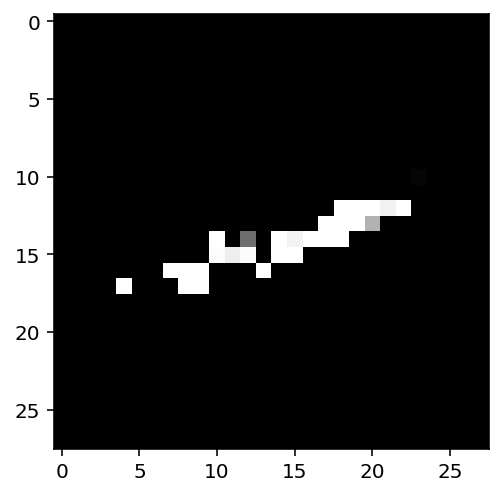

In [17]:
image = adversarial_samples[10][2].squeeze()
plt.imshow(image, cmap="gray")

# Save adversarial data

In [25]:
from pathlib import Path
hdf5_dir = Path("../saved_models/Carlini/vanilla/adversarial_samples_model_01")
hdf5_dir.mkdir(parents=True, exist_ok=True)

In [150]:
# CONSTANTS 
constants = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 10]

In [19]:
def store_adversarial_data(images, init):
    num_images = len(images)
#     Create HDF5 file
    file = h5py.File(hdf5_dir / f"{init}.h5", "w")
#     Create dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.IEEE_F32BE, data=images
    )
    file.close()
    
def read_adversarial_data(init):
    images = []
    file = h5py.File(hdf5_dir / f"{init}.h5", "r+")
    images = np.array(file["/images"]).astype("float32")
    file.close()
    return images

In [29]:
# STORE
constants = [0.5, 5]
for init in constants:
    store_adversarial_data(adversarial_samples[init], init)

In [26]:
# READ
adversarial_test = dict()
for init in constants:
    adversarial_test[init] = read_adversarial_data(init)   

In [27]:
# TEST
res = dict()
for init, x_test_adv in adversarial_test.items():
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    res[init] = accuracy*100
    print("init_const: {} - Accuracy on adversarial test examples: {}%".format(init, accuracy * 100))

init_const: 0.1 - Accuracy on adversarial test examples: 98.32%
init_const: 1.0 - Accuracy on adversarial test examples: 59.61%
init_const: 10 - Accuracy on adversarial test examples: 5.72%


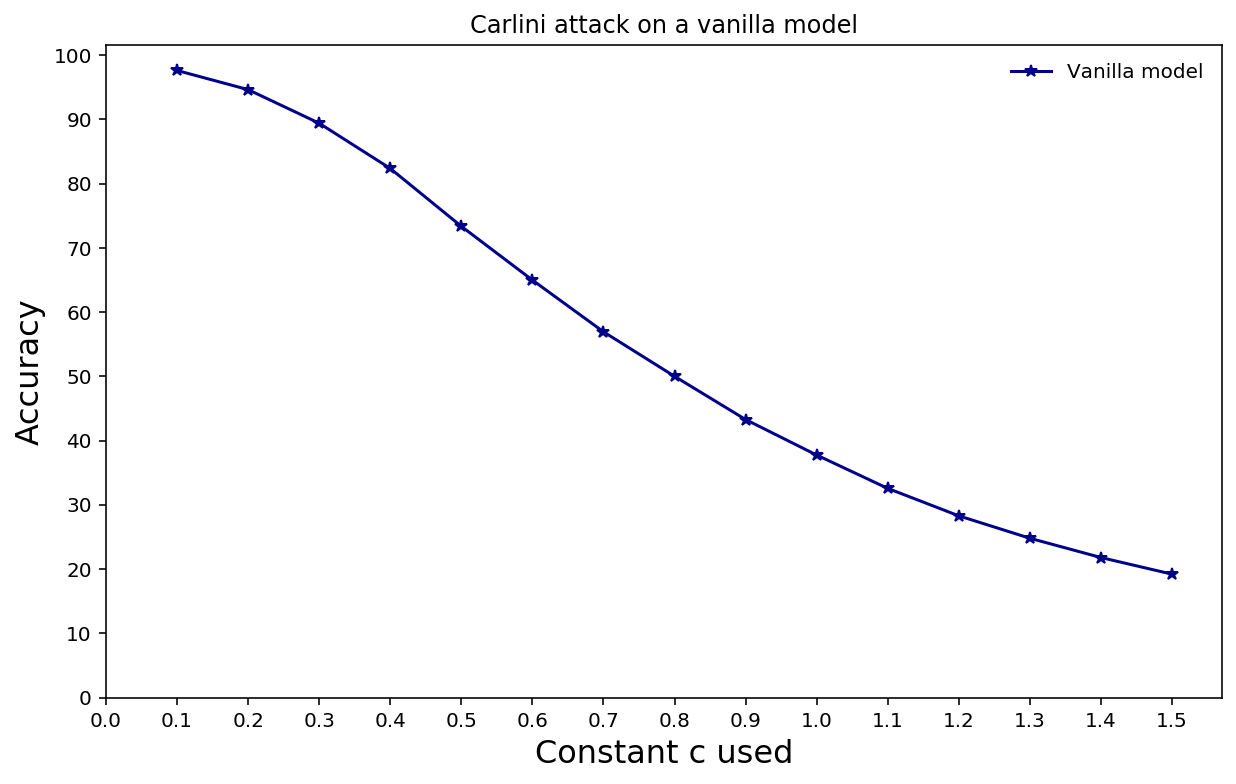

In [157]:
from collections import OrderedDict

plt.figure(figsize=(10,6))
results = OrderedDict(sorted(res.items()))
x = list(results.keys())
y = list(results.values())
plt.plot(x[:-1], y[:-1], "*-", label='Vanilla model', color='darkblue')

plt.yticks(np.arange(0, 110, step=10))
plt.xticks(np.arange(0, 1.6, step=0.1))
plt.title("Carlini attack on a vanilla model")
plt.xlabel("Constant c used",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()